In [1]:
import numpy as np
from scipy.optimize import fsolve
from controller import PI_Controller
import matplotlib.pyplot as plt

In [2]:
def angle_wrap(angle):
    a = angle%(2*np.pi)
    if abs(a - 2*np.pi)<1e-3:
        a = 0
    return (a)

In [3]:
class PUMA():
    def __init__(self,d1=1,a2=1,a3=1):
        self.d1 = d1
        self.a2 = a2
        self.a3 = a3
        self.q1 = 0
        self.q2 = 0
        self.q3 = 0

        self.update_endEffectorPosition()

    def update_endEffectorPosition(self,):
        self.xE,self.yE,self.zE = self.forward_kinematics(self.q1,self.q2,self.q3)
    
    def inverse_kinematics(self,xc,yc,zc):

        # Workspace condition
        D = (xc**2 + yc**2 + (zc-self.d1)**2 - self.a2**2 - self.a3**2)/(2*self.a2*self.a3)
        if abs(D)<=1:
            def inv_func(x):
                return [
                        -xc + self.a2*np.cos(x[1])*np.cos(x[0]) + self.a3*np.cos(x[1]+x[2])*np.cos(x[0]),
                        -yc + self.a2*np.cos(x[1])*np.sin(x[0]) + self.a3*np.cos(x[1]+x[2])*np.sin(x[0]),
                        -zc + self.d1 + self.a2*np.sin(x[1]) + self.a3*np.sin(x[1]+x[2])
                        ]
            root = fsolve(inv_func,[0,0,0])
            q1,q2,q3 = root
            
            self.q1,self.q2,self.q3 = angle_wrap(q1),angle_wrap(q2),angle_wrap(q3)
            # Returns True if solution exists
            return True, [self.q1,self.q2,self.q3]
        else:
            # Returns True if solution exists
            print("Angles provided not in workspace")
            return False, [None, None, None]
    
    def forward_kinematics(self,q1,q2,q3):
        xc = self.a2*np.cos(q2)*np.cos(q1) + self.a3*np.cos(q2+q3)*np.cos(q1)
        yc = self.a2*np.cos(q2)*np.sin(q1) + self.a3*np.cos(q2+q3)*np.sin(q1)
        zc = self.d1 + self.a2*np.sin(q2) + self.a3*np.sin(q2+q3)

        self.xE,self.yE,self.zE = xc,yc,zc

        return xc,yc,zc
    
    def dynamics(self,):
        
        pass
    def point_tracking(self,trk_points):
        # dh = 
        # TMatrix = 
        xt,yt,zt = trk_points

        ret, angles = self.inverse_kinematics(xt,yt,zt)
        if ret:
            print(angles) 
        else:
            print('Error Occurred! Exiting ...')

In [35]:
class SCARA():
    def __init__(self,d=1,a1 = 1, a2=1, gains  = [[10,0,0],
                                                  [20,0,0],
                                                  [10,0,0]]):
        self.d = d
        self.a1 = a1
        self.a2 = a2
        self.a3 = 1

        self.m1 = 1
        self.m2 = 1
        self.m3 = 1


        self.x = np.zeros(3)
        self.x_dot = np.zeros(3)
        self.x_d_dot = np.zeros(3)


        self.tau_1 = 0
        self.tau_2 = 0
        self.F_3 = 0

        self.compute_inertias()

        self.update_endEffectorPosition()

        self.controller = PI_Controller(gains)

    def compute_inertias(self,):
        self.J1 = (1/3)*self.m1*self.a1*2
        self.J2 = (1/3)*self.m2*self.a2*2
        self.J3 = (1/3)*self.m3*self.a3*2

    def update_endEffectorPosition(self,):
        self.forward_kinematics()

    def inverse_kinematics(self,pos):
        xc,yc,zc = pos
        # Workspace condition
        if np.sqrt(xc**2+yc**2)>self.a2 + self.a1:
            print("No Solution can be Found!")
            return False,[None, None, None]
        else: 
            def inv_func(x):
                return [
                        - xc + self.a1*np.cos(x[0]) + self.a2*np.cos(x[0]+x[1]),
                        - yc + self.a1*np.sin(x[0]) + self.a2*np.sin(x[0]+x[1]),
                        - zc + self.d - x[2]
                        ]
            root = fsolve(inv_func,[1,1,1])

            q1,q2,d = root

            return True, [angle_wrap(q1),angle_wrap(q2),d]
    
    def forward_kinematics(self):

        xc = self.a1*np.cos(self.x[0]) + self.a2*np.cos(self.x[0] + self.x[1])
        yc = self.a1*np.sin(self.x[0]) + self.a2*np.sin(self.x[0] + self.x[1])
        zc = self.d - self.x[2]

        self.xE,self.yE,self.zE = xc,yc,zc

        return xc,yc,zc
    
    def dynamics_solver(self,dt,x_des):
        
        g  = 9.8

        e = x_des - self.x

        alpha = self.J1 + self.a1**2*(self.m1/4 + self.m2 + self.m3)
        beta = self.J2 + self.J3 + self.a2**2*(self.m2/4 +self.m3) 
        gamma = self.a1*self.a2*self.m3 + self.a1 * self.a2/2 * self.m2

        self.tau_1,self.tau_2,self.F_3 = self.controller.track_angles(e)

        # Damping term
        d = 0.0
        self.tau_1 = self.tau_1 - d*self.x_dot[0]
        self.tau_2 = self.tau_2 - d*self.x_dot[1]
        self.F_3 = self.F_3 - d*self.x_dot[2]

        u1 = -gamma*np.sin(self.x[1])*self.x_dot[1]*self.x_dot[0] - gamma*np.sin(self.x[1])*(self.x_dot[1] + self.x_dot[0])*self.x_dot[1] + self.tau_1
        u2 = gamma*np.sin(self.x[1])*self.x_dot[0]**2 + self.tau_2
        u3 = self.m3*g + self.F_3

        MM = np.around(np.array([[alpha + beta + 2*gamma*np.cos(self.x[1]), beta + 2*gamma*np.cos(self.x[1]), 0],
                       [beta + 2*gamma*np.cos(self.x[1]), beta, 0],
                       [0, 0, self.m3]]) , decimals= 4)
        
        
        C = np.around(np.array([[-gamma*np.sin(self.x[1])*self.x_dot[1], -gamma*np.sin(self.x[1])*(self.x_dot[1] + self.x_dot[0]), 0],
                      [gamma*np.sin(self.x[1])*self.x_dot[0], 0, 0],
                      [0, 0, 0]]), decimals = 4)
        G = np.around(np.transpose(np.array([0, 0, self.m3*g])), decimals = 4)

        U = np.around(np.transpose(np.array([u1, u2,u3])), decimals = 4)

        K = np.around((U - np.matmul(C, np.transpose(self.x_dot))-G), decimals = 4)

        d2ydt2 = np.around(np.matmul(np.linalg.inv(MM), K), decimals = 4)


        self.x_dot = self.x_dot + d2ydt2*dt
        self.x = self.x_dot*dt + 1/2*d2ydt2*dt**2
        for i in range(2):
            self.x[i] = angle_wrap(self.x[i])
        
        self.update_endEffectorPosition()


    
    def point_tracking(self,trk_points):

        xt,yt,zt = trk_points

        ret, angles = self.inverse_kinematics([xt,yt,zt])
  
        max_time = 100
        num_steps = 3000
        t = np.linspace(0,max_time,num=num_steps )
        y = []
        y_inv = []
        y.append(self.x)
        y_inv.append([self.xE,self.yE,self.zE])

        for i in range(len(t)):
            self.dynamics_solver(max_time/num_steps,angles)
            y.append(self.x)
            y_inv.append([self.xE,self.yE,self.zE])
            

        return np.array(y),np.array(y_inv)
        # return y


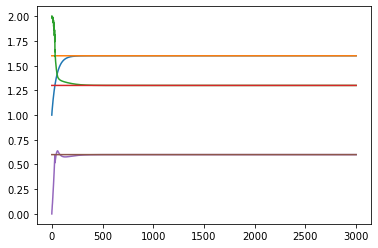

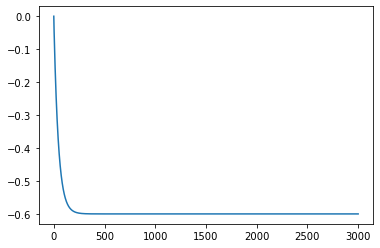

In [37]:
s = SCARA(gains  = [[43,0.9,0.0],
                    [20,0.5,0.0],
                    [20,0.0,0]])
x_t = 1.3
y_t = 0.6
z_t = 1.6

y,y_inv = s.point_tracking([x_t,y_t,z_t])
plt.figure(1)
plt.plot(y_inv[:,2])
plt.plot(np.ones_like(y_inv[:,2])*z_t)
plt.plot(y_inv[:,0])
plt.plot(np.ones_like(y_inv[:,2])*x_t)
plt.plot(y_inv[:,1])
plt.plot(np.ones_like(y_inv[:,2])*y_t)


plt.figure(2)
plt.plot(y[:,2])

# plt.plot(y[:,0])/
# plt.plot(y[:,1])

